# Model visualisation

- **Author**: Jack Oliver
- **Date**: 30/04/2024
- **Purpose**: Create a draft visualisation to visually examine model dynamics.

## Imports & data

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import os, datetime

# import matplotlib_inline.backend_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

import IPython
from IPython.display import display, HTML

from model import *
from model_presets import BASELINE_MODEL, HIGH_MOVEMENT

## Visualisation experiment

In [2]:
m = BaselineModel(**BASELINE_MODEL)
data, _ = m.run(with_progress=True)

100%|████████████████████████████████████████| 800/800 [00:05<00:00, 159.74it/s]


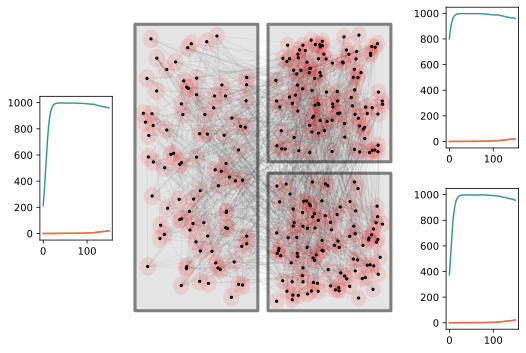

In [34]:
# Configure layout

scale_factor = 1.2

fig = plt.figure(constrained_layout=True, figsize=(6*scale_factor, 4*scale_factor))
gs  = fig.add_gridspec(nrows=4, ncols=6)

sei1 = fig.add_subplot(gs[1:3, 0])
sei2 = fig.add_subplot(gs[:2, 5])
sei3 = fig.add_subplot(gs[2:, 5])
sei_plots = [sei1, sei2, sei3]

patch_area = fig.add_subplot(gs[:, 1:5])
patch_area.xaxis.set_ticklabels([])
patch_area.yaxis.set_ticklabels([])
patch_area.set_xticks([])
patch_area.set_yticks([])

for spine in ['top','bottom','left','right']:
    patch_area.spines[spine].set_linewidth(0)

# Create boxes representing patches
mid_sep = .48
padding = .03
patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]

for p_args in patch_rects:
    patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
    patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))

# Set node locations and plot
patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                   np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in m.patches[k].nodes} for k in range(len(m.patches))}
node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}
nx.draw_networkx_nodes(m.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
nx.draw_networkx_edges(m.graph, pos=node_pos, ax=patch_area, alpha=.05)

t = 600 # time in ticks

# Display vector SEI progression so far
for patch_id in range(3):
    for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
        sei_plots[patch_id].plot(np.linspace(0, t/4, t), data["patch_sei"][patch_id][:t, i], color=c)


# Display current heatmap of disease in ABM
max_rad = .1
for node_id in range(300):
    if (i_val:=data["node_seir"][node_id][t][2]) > 0:
        patch_area.add_patch(mpatches.Circle(node_pos[node_id], radius=1*i_val/np.sum(data["node_seir"][node_id][t]), linewidth=None, facecolor='red', alpha=.1))

plt.show()

## Visualisation animation

In [2]:
def make_visualisation_from_model(model, num_frames=10, scale_factor=1.2, save_to="saved_runs"):
    """Makes a visualisation"""
    # Run model
    print("Running model...")
    data, _ = model.run(with_progress=True)
    
    # Calculate sampling rate for animation
    tick_samples = list(map(int,np.linspace(0, model.total_time/model.timestep-1, num_frames)))
    
    # Initialise node locations and plot
    mid_sep = .48
    padding = .03
    patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]
    patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                       np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in model.patches[k].nodes} for k in range(len(model.patches))}
    node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}

    # Create loc to save
    dirname = f"{save_to}/{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_run"
    os.makedirs(dirname)
    
    # Run visualisation loop
    print("Animating model...")
    for t in tqdm_notebook(tick_samples):
        # Configure layout
        fig = plt.figure(constrained_layout=True, figsize=(6*scale_factor, 4*scale_factor))
        gs  = fig.add_gridspec(nrows=4, ncols=6)
        
        sei1 = fig.add_subplot(gs[1:3, 0])
        sei2 = fig.add_subplot(gs[:2, 5])
        sei3 = fig.add_subplot(gs[2:, 5])
        sei_plots = [sei1, sei2, sei3]

        for i, ax in enumerate(sei_plots):
            ax.set_ylim(0, model.K_v_arr[i])
        
        patch_area = fig.add_subplot(gs[:, 1:5])
        patch_area.xaxis.set_ticklabels([])
        patch_area.yaxis.set_ticklabels([])
        patch_area.set_xticks([])
        patch_area.set_yticks([])
        
        for spine in ['top','bottom','left','right']:
            patch_area.spines[spine].set_linewidth(0)
            
        for p_args in patch_rects:
            patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
            patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))
        
        nx.draw_networkx_nodes(model.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
        nx.draw_networkx_edges(model.graph, pos=node_pos, ax=patch_area, alpha=.05)
        
        # Display vector SEI progression so far
        for patch_id in range(3):
            for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
                sei_plots[patch_id].plot(np.linspace(0, t/4, t), data["patch_sei"][patch_id][:t, i], color=c)
        
        
        # Display current heatmap of disease in ABM
        max_rad = .1
        for node_id in range(300):
            if (i_val:=data["node_seir"][node_id][t][2]) > 0:
                patch_area.add_patch(mpatches.Circle(node_pos[node_id], radius=1*i_val/np.sum(data["node_seir"][node_id][t]), linewidth=None, facecolor='red', alpha=.1))

        plt.savefig(f"{dirname}/{t}.png")
        plt.close()

In [3]:
make_visualisation_from_model(BaselineModel(**BASELINE_MODEL), num_frames=10)

Running model...


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 150.89it/s]

Animating model...


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
make_visualisation_from_model(BaselineModel(**HIGH_MOVEMENT), num_frames=50)

Running model...


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 160.30it/s]

Animating model...


  0%|          | 0/50 [00:00<?, ?it/s]

* Use matplotlib animation functionality rather than saving as multiple images

In [43]:
def make_visualisation(model, num_frames=10, scale_factor=1.2, display=True, save=False, save_to="saved_runs"):
    """Makes a visualisation of the model run. Takes ~0.3s to render each tick."""
    # Run model
    print("Running model...")
    data, _ = model.run(with_progress=True)
    
    # Calculate sampling rate for animation
    tick_samples = list(map(int,np.linspace(0, model.total_time/model.timestep-1, num_frames)))
    
    # Initialise node locations and plot
    mid_sep = .48
    padding = .03
    patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]
    patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                       np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in model.patches[k].nodes} for k in range(len(model.patches))}
    node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}
    
    # Configure layout of plots
    fig = plt.figure(constrained_layout=True, figsize=(6*scale_factor, 4*scale_factor))
    gs  = fig.add_gridspec(nrows=4, ncols=6)
    
    sei1 = fig.add_subplot(gs[1:3, 0])
    sei2 = fig.add_subplot(gs[:2, 5])
    sei3 = fig.add_subplot(gs[2:, 5])
    sei_axes = [sei1, sei2, sei3]
    sei_plots = [[None] * 3 for _ in range(3)]
    
    for i, ax in enumerate(sei_axes):
        ax.set_xlim(0, 200)
        ax.set_ylim(0, model.K_v_arr[i])
    
    patch_area = fig.add_subplot(gs[:, 1:5])
    patch_area.xaxis.set_ticklabels([])
    patch_area.yaxis.set_ticklabels([])
    patch_area.set_xticks([])
    patch_area.set_yticks([])
    
    for spine in ['top','bottom','left','right']:
        patch_area.spines[spine].set_linewidth(0)
        
    for p_args in patch_rects:
        patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
        patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))
    
    nx.draw_networkx_nodes(model.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
    nx.draw_networkx_edges(model.graph, pos=node_pos, ax=patch_area, alpha=.05)
    
    
    # Display initial vector SEI progression
    init_t = tick_samples[0]
    
    for patch_id in range(3):
        for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
            sei_plots[patch_id][i] = sei_axes[patch_id].plot(np.linspace(0, init_t/4, init_t), data["patch_sei"][patch_id][:init_t, i], color=c)[0]
    
    # Display current heatmap of disease in ABM
    node_patches = []
    
    max_rad = .1
    for node_id in range(300):
        if (i_val:=data["node_seir"][node_id][init_t][2]) > 0:
            cur_patch = mpatches.Circle(node_pos[node_id], radius=1*i_val/np.sum(data["node_seir"][node_id][init_t]), linewidth=None, facecolor='red', alpha=.1)
    
            node_patches.append(cur_patch)
            patch_area.add_patch(cur_patch)
    
    # Define method to update all plots
    def update(t):
        artists = []
        # Display vector SEI progression so far
        for patch_id in range(3):
            for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
                sei_plots[patch_id][i].set_xdata(np.linspace(0, t/4, t))
                sei_plots[patch_id][i].set_ydata(data["patch_sei"][patch_id][:t, i])
                
                artists.append(sei_plots[patch_id][i])
        
        # Display current heatmap of disease in ABM
        for node_id, patch in enumerate(node_patches):
            if (i_val:=data["node_seir"][node_id][t][2]) > 0:
                radius=.5*i_val/np.sum(data["node_seir"][node_id][t])
                patch.set_radius(radius)
                # patch.set_height(radius)
    
                # artists.append(patch)
            
        return artists

    print("Creating animation...")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=tick_samples[1:], interval=100)

    if display:
        return HTML(ani.to_jshtml())

    if save:
        # Create loc to save
        filename = f"{save_to}/{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_run"
        os.makedirs(f"{save_to}/")
        
        ani.save(filename=filename+".gif", writer="pillow")

* Make size of circle = number of agents; colour = majority class

In [16]:
def make_visualisation(model, data=None, num_frames=10, scale_factor=1.2, display=True, save=False, save_to="saved_runs", display_agents_seir=True, filename=None):
    """Makes a visualisation of the model run. Takes ~0.3s to render each tick."""
    assert num_frames > 1, "`num_frames` must be > 0."
    
    # Run model or use existing run
    if data is None:
        print("Running model...")
        data, _ = model.run(with_progress=True)
    
    # Calculate sampling rate for animation
    tick_samples = list(map(int,np.linspace(0, model.total_time/model.timestep-1, num_frames)))
    
    # Initialise node locations and plot
    mid_sep = .48
    padding = .03
    patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]
    patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                       np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in model.patches[k].nodes} for k in range(len(model.patches))}
    node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}
    
    # Configure layout of plots
    fig = plt.figure(constrained_layout=True,
                     figsize=((6+1)*scale_factor, (5)*scale_factor))
    gs  = fig.add_gridspec(nrows=5, ncols=6, height_ratios=[1, 1, 1, 1, 1.5], width_ratios=[2.5, 1, 3, 3, 1, 2.5])
    
    sei1 = fig.add_subplot(gs[1:3, 0])
    sei2 = fig.add_subplot(gs[:2, 5])
    sei3 = fig.add_subplot(gs[2:4, 5])
    sei_axes = [sei1, sei2, sei3]
    sei_plots = [[None] * 3 for _ in range(3)]
    
    for i, ax in enumerate(sei_axes):
        ax.set_xlim(0, 200)
        ax.set_ylim(0, model.K_v_arr[i])

        if i == 1 or i == 2: ax.yaxis.tick_right()

    seir_ax = fig.add_subplot(gs[4, :])
    seir_ax.set_xlim(0, 200)
    seir_ax.set_ylim(0, model.num_agents)
    seir_ax.spines["top"].set_linewidth(0)
    seir_ax.spines["right"].set_linewidth(0)
    
    patch_area = fig.add_subplot(gs[:4, 1:5])
    patch_area.xaxis.set_ticklabels([])
    patch_area.yaxis.set_ticklabels([])
    patch_area.set_xticks([])
    patch_area.set_yticks([])
    
    for spine in ['top','bottom','left','right']:
        patch_area.spines[spine].set_linewidth(0)
        
    for p_args in patch_rects:
        patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
        patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))
    
    # nx.draw_networkx_nodes(model.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
    nx.draw_networkx_edges(model.graph, pos=node_pos, ax=patch_area, alpha=.05)
    
    
    # Display initial plots
    init_t = tick_samples[0]
    
    for patch_id in range(3):
        for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
            sei_plots[patch_id][i] = sei_axes[patch_id].plot(np.linspace(0, init_t/4, init_t), data["patch_sei"][patch_id][:init_t, i], color=c)[0]

    seir_plots = [None, None, None, None]
    for (i, c) in zip(range(4), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"]):
        seir_plots[i] = seir_ax.plot(np.linspace(0, init_t/4, init_t), data["agent_disease_counts"][i][:init_t], color=c)[0]
    
    # Display nodes in ABM
    node_patches = []
    
    scale_rad = 5
    node_colors = ["#41949A", "#e79f31", "#E56E5A", "#7384BB"]
    for node_id in range(300):
        # print(node_id,
        #       np.sum(data["node_seir"][node_id][init_t]),
        #       np.sum(data["node_seir"][node_id][init_t])/model.num_agents)
        cur_patch = mpatches.Circle(node_pos[node_id],
                                    radius=scale_rad*np.sum(data["node_seir"][node_id][init_t])/model.num_agents,
                                    linewidth=1,
                                    edgecolor='black',
                                    facecolor=node_colors[np.argmax(data["node_seir"][node_id][init_t])])

        node_patches.append(cur_patch)
        patch_area.add_patch(cur_patch)
    
    # Define method to update all plots
    def update(t):
        artists = []
        # Display vector SEI progression so far
        for patch_id in range(3):
            for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
                sei_plots[patch_id][i].set_xdata(np.linspace(0, t/4, t))
                sei_plots[patch_id][i].set_ydata(data["patch_sei"][patch_id][:t, i])
                
                artists.append(sei_plots[patch_id][i])
        
        # Display current heatmap of disease in ABM
        for node_id, patch in enumerate(node_patches):
            patch.set_radius(scale_rad*np.sum(data["node_seir"][node_id][t])/model.num_agents)

            # TODO: change this to be majority always?
            # if data["node_seir"][node_id][t][2] > 0:
                # patch.set_facecolor(node_colors[2])
            # else:
            patch.set_facecolor(node_colors[np.argmax(data["node_seir"][node_id][t])])
    
        # artists.append(patch_area)

        for i, seir_plot in enumerate(seir_plots):
            seir_plot.set_data(np.linspace(0, t/4, t), data["agent_disease_counts"][i][:t])

            artists.append(seir_plot)
            
        return artists

    print("Creating animation...")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=tick_samples[1:], interval=100)

    if save:
        # Create loc to save
        filename = f"{save_to}/{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_run" if filename is None else f"{save_to}/{filename}"
        os.makedirs(f"{save_to}/", exist_ok=True)
        
        ani.save(filename=filename+".gif", writer="pillow")
    
    if display:
        return HTML(ani.to_jshtml())

In [4]:
m = BaselineModel(**HIGH_MOVEMENT)
data, _ = m.run(with_progress=True)

100%|████████████████████████████████████████| 800/800 [00:05<00:00, 149.45it/s]


In [19]:
%%time
make_visualisation(m, data=data, num_frames=2, display=True, save=True, scale_factor=1)

<IPython.core.display.Javascript object>

Creating animation...
CPU times: user 1.16 s, sys: 60.7 ms, total: 1.22 s
Wall time: 1.21 s
